In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

import scipy.stats as stats

In [282]:
# Load the CSV file
file_train_path = './CETC331/Training_CETC331.csv'
file_test_path = './CETC331/Testing_CETC331.csv'

test_data = pd.read_csv(file_test_path)
train_data = pd.read_csv(file_train_path)

training_summary = train_data.describe()
testing_summary = test_data.describe()

train_data.head(), test_data.head(), training_summary.iloc[:, :10], testing_summary.iloc[:, :10]

(   MAC1  MAC2  MAC3  MAC4  MAC5  MAC6  MAC7  MAC8  MAC9  MAC10  ...  MAC51  \
 0   -44   -48   -71   -85   -92   100   100   100   -88    100  ...    100   
 1   -37   -50   -72   -85   -93   100   -93   100   -86    100  ...    100   
 2   -41   -51   -68   -84   -88   100   -93   100   -84    100  ...    100   
 3   -38   -50   -67   -89   -83   -90   -92   100   -83    100  ...    100   
 4   -35   -57   -63   -87   -86   -87   100   100   -81    100  ...    100   
 
    MAC52  ECoord  NCoord  FloorID  BuildingID  SceneID  UserID  PhoneID  \
 0    100    45.0    17.5        1           1        1       4        3   
 1    100    45.5    17.5        1           1        1       4        3   
 2    100    46.0    17.5        1           1        1       4        3   
 3    100    46.5    17.5        1           1        1       4        3   
 4    100    46.9    17.5        1           1        1       4        3   
 
    SampleTimes  
 0            1  
 1            1  
 2          

In [283]:
irrelevant_features = ['ECoord', 'NCoord', 'FloorID', 'BuildingID', 'SceneID', 'UserID', 'PhoneID', 'SampleTimes']

output_variables = ['ECoord', 'NCoord']

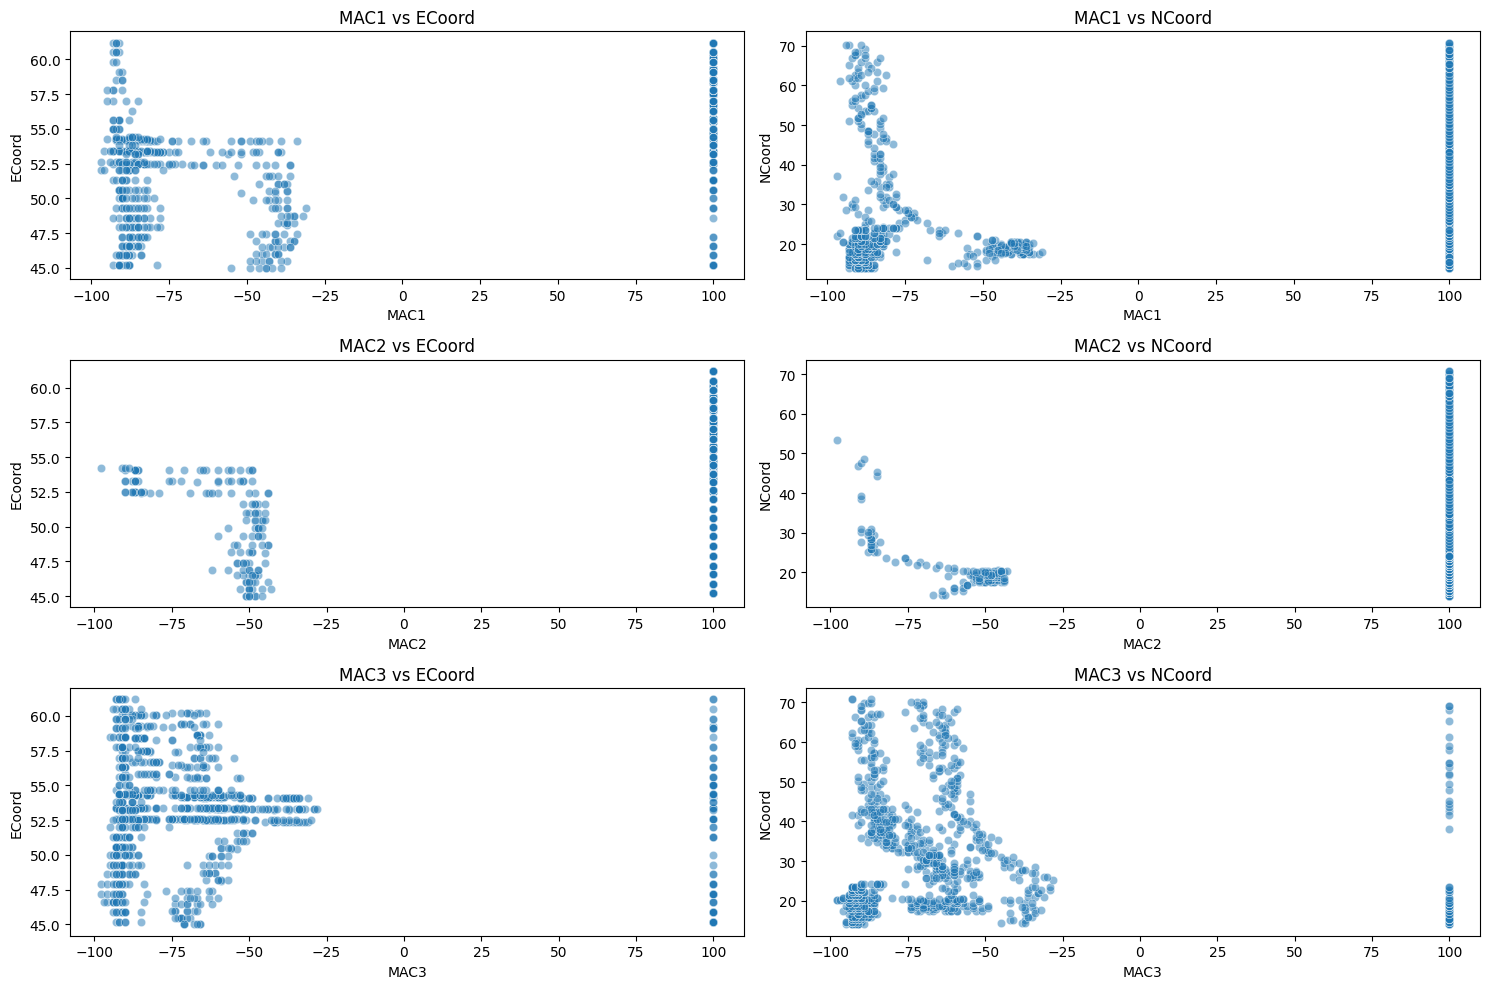

In [284]:
rssi_columns = ['MAC1', 'MAC2', 'MAC3']

# Setting up the plotting
fig, axes = plt.subplots(len(rssi_columns), len(output_variables), figsize=(15, 10))

for i, rssi_col in enumerate(rssi_columns):
    for j, output_var in enumerate(output_variables):
        # Scatter plot for each combination of RSSI value and output variable
        sns.scatterplot(x=train_data[rssi_col], y=train_data[output_var], ax=axes[i, j], alpha=0.5)
        axes[i, j].set_title(f'{rssi_col} vs {output_var}')

plt.tight_layout()
plt.show()

In [285]:
# Relevant data for training
train_data_input = train_data.drop(irrelevant_features, axis=1).replace(100, -200)
test_data_input = test_data.drop(irrelevant_features, axis=1).replace(100, -200)
Y_train = train_data[output_variables]
Y_test = test_data[output_variables]

In [286]:
# num_components = np.arange(0.6, 1.0, 0.01)
# errors = []

# for n_comp in num_components:
#     pca = PCA(n_components=n_comp)
#     X_train_pca = pca.fit_transform(train_data_input)
#     scores = cross_val_score(LinearRegression(), X_train_pca, Y_train, cv=10, scoring='neg_mean_squared_error')
#     model = LinearRegression().fit(X_train_pca, Y_train)
#     errors.append((-scores.mean()) ** 0.5)
    

# plt.figure(figsize=(10, 6))
# plt.plot(num_components, errors, marker='o', linestyle='-', color='b')
# plt.xticks(np.arange(0.6, 1.0, 0.05))
# plt.title('Model Error Rate vs. Number of Principal Components')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Error Rate')
# plt.grid(True)
# plt.show()

In [287]:
pca = PCA(n_components=0.77)
X_train = pca.fit_transform(train_data_input)

# The number of components after PCA
n_components = X_train.shape[1]

n_components

3

In [288]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# confirm scaling has been done properly
X_train.mean(), X_train.std()

(1.9840634855430373e-17, 1.0)

In [289]:
# Same PCA
X_test = pca.transform(test_data_input)

# Apply scaler
X_test = scaler.transform(X_test) 

In [290]:
# Training a linear regression model for ECoord
multi_cv_scores = cross_val_score(LinearRegression(), X_train, Y_train, cv=5, scoring='neg_mean_squared_error')

e_cv_scores = cross_val_score(LinearRegression(), X_train, Y_train['ECoord'], cv=5, scoring='neg_mean_squared_error')
n_cv_scores = cross_val_score(LinearRegression(), X_train, Y_train['NCoord'], cv=5, scoring='neg_mean_squared_error')

# Compute the average RMSE across the cross-validation folds
multi_average_rmse = (-multi_cv_scores.mean()) ** 0.5
e_avg_rmse = (-e_cv_scores.mean()) ** 0.5 
n_avg_rmse = (-n_cv_scores.mean()) ** 0.5

multi_average_rmse, (e_avg_rmse + n_avg_rmse)/2

(6.0169833505210235, 5.984115459463295)

In [291]:
multi_model = LinearRegression().fit(X_train, Y_train)
e_model = LinearRegression().fit(X_train, Y_train['ECoord'])
n_model = LinearRegression().fit(X_train, Y_train['NCoord'])

y_pred = multi_model.predict(X_test)
predictions_df = pd.DataFrame(y_pred, columns=['Pred_ECoord', 'Pred_NCoord'])
multi_rmse_test = root_mean_squared_error(Y_test, predictions_df)
multi_r2_score = r2_score(Y_test, y_pred)

e_y_pred = e_model.predict(X_test)
n_y_pred = n_model.predict(X_test)

e_rmse_test = root_mean_squared_error(Y_test['ECoord'], e_y_pred)
n_rmse_test = root_mean_squared_error(Y_test['NCoord'], n_y_pred)

e_r2_score = r2_score(Y_test['ECoord'], e_y_pred)
n_r2_score = r2_score(Y_test['NCoord'], n_y_pred)

(multi_rmse_test, multi_r2_score), ((e_rmse_test + n_rmse_test)/2, (e_r2_score + n_r2_score)/2)

((5.330179116764809, 0.5046063704592648),
 (5.330179116764805, 0.5046063704592647))

C:\Users\gps18.REMAINHEALTHY\AppData\Local\Temp\ipykernel_24276\2691015462.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 100)


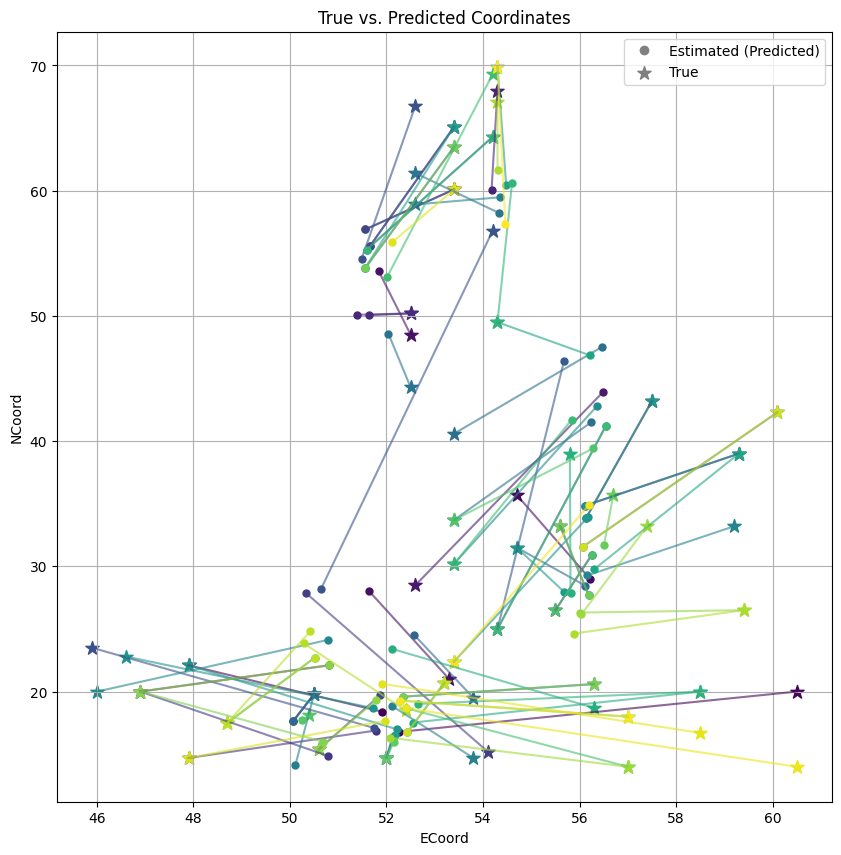

In [292]:
def true_vs_predicted(X_test, Y_test, model, transform=lambda x:x):
    np.random.seed(42)
    random_indices = np.random.choice(X_test.shape[0], size=100, replace=False)
    X_test_random = X_test[random_indices]

    y_pred_random = transform(model.predict(X_test_random))

    y_test_random = Y_test.loc[random_indices]

    # Preparing the visualization
    plt.figure(figsize=(10, 10))
    cmap = plt.cm.get_cmap('viridis', 100)

    for i, (true, pred) in enumerate(zip(y_test_random.values, y_pred_random)):
            color = cmap(i)
            plt.plot([true[0], pred[0]], [true[1], pred[1]], '-', alpha=0.6, color=color)
            plt.plot(pred[0], pred[1], 'o', markersize=5, color=color)
            plt.scatter(true[0], true[1], marker='*', s=100, color=color)  

    plt.plot([], [], 'o', color='gray', label='Estimated (Predicted)')
    plt.scatter([], [], marker='*', s=100, color='gray', label='True')

    plt.legend()
    plt.title('True vs. Predicted Coordinates')
    plt.xlabel('ECoord')
    plt.ylabel('NCoord')
    plt.grid(True)

true_vs_predicted(X_test, Y_test, multi_model)

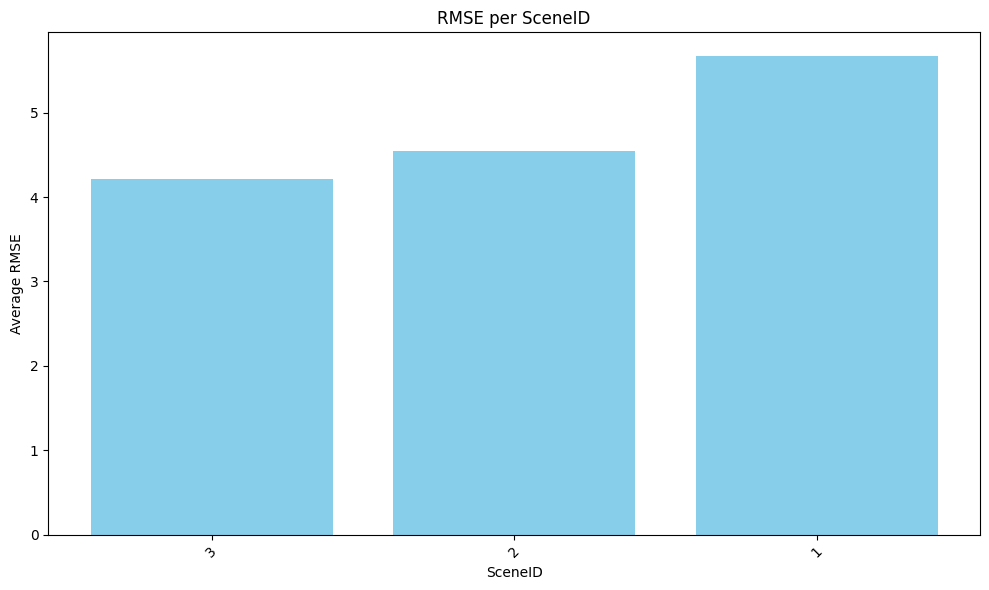

In [293]:
rmse_values = []

# Iterate over each SceneID
for scene_id in test_data['SceneID'].unique():
    # Filter the data for the current SceneID
    df_scene = test_data[test_data['SceneID'] == scene_id]
    
    X_scene = df_scene.drop(irrelevant_features, axis=1)
    y_true_scene = df_scene[['ECoord', 'NCoord']]
    
    X_scene = X_scene.replace(100, -200)

    X_scene = pca.transform(X_scene)  

    X_scene = scaler.transform(X_scene)

    y_pred_scene = multi_model.predict(X_scene)

    rmse_ecoord = np.sqrt(mean_squared_error(y_true_scene['ECoord'], y_pred_scene[:, 0]))
    rmse_ncoord = np.sqrt(mean_squared_error(y_true_scene['NCoord'], y_pred_scene[:, 1]))
    
    rmse_avg = (rmse_ecoord + rmse_ncoord) / 2
    
    rmse_values.append((scene_id, rmse_avg))

rmse_df = pd.DataFrame(rmse_values, columns=['SceneID', 'RMSE'])

rmse_df = rmse_df.sort_values('RMSE')


plt.figure(figsize=(10, 6))
plt.bar(rmse_df['SceneID'].astype(str), rmse_df['RMSE'], color='skyblue')
plt.xlabel('SceneID')
plt.ylabel('Average RMSE')
plt.title('RMSE per SceneID')
plt.xticks(rotation=45)
plt.tight_layout()

It is necessary to check if all the assumptions for applying linear regression are met. So I define functions to check for homoscedacity and normality.

In [294]:
def residual_plot_both(y_pred, residuals):
    # Plot for ECoord
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.scatter(y_pred[:, 0], residuals['ECoord'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs. Predicted for ECoord')
    plt.xlabel('Predicted ECoord')
    plt.ylabel('Residuals')

    # Plot for NCoord
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.scatter(y_pred[:, 1], residuals['NCoord'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs. Predicted for NCoord')
    plt.xlabel('Predicted NCoord')

    plt.tight_layout()
    plt.show()

In [295]:
def qq_plot(residuals):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    stats.probplot(residuals['ECoord'], dist="norm", plot=plt)
    plt.title('Q-Q plot for ECoord residuals.')

    plt.subplot(1, 2, 2)
    stats.probplot(residuals['NCoord'], dist="norm", plot=plt)
    plt.title('Q-Q plot for NCoord residuals.')

    plt.tight_layout()
    plt.show()

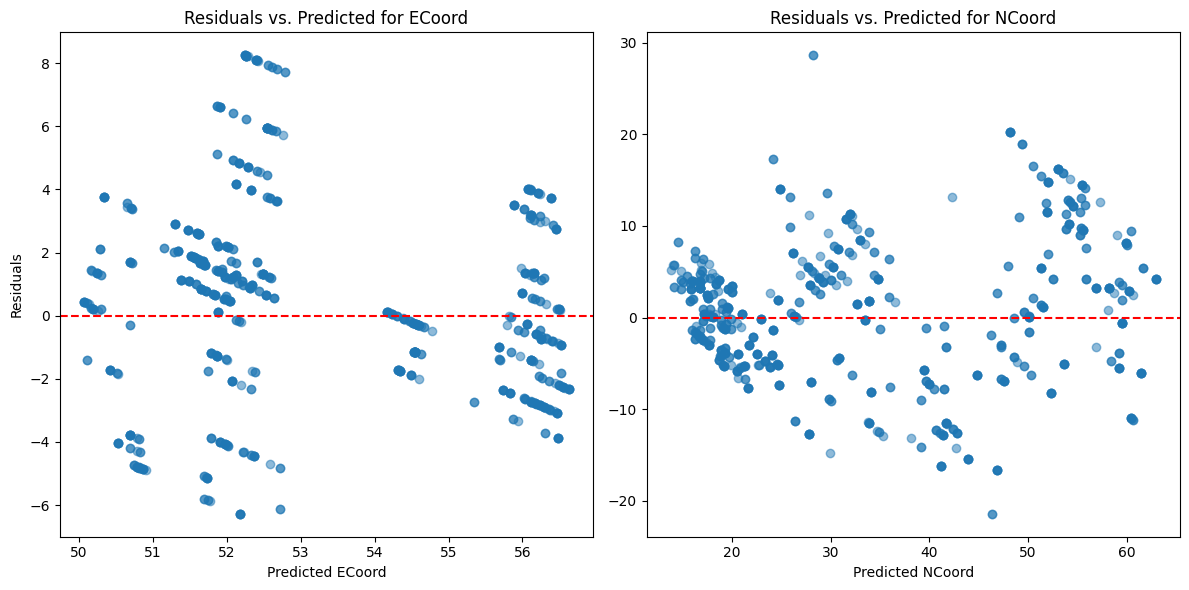

In [296]:
# both y_test and y_pred hold ECoord and NCoord values, except one is a dataframe the other is a numpy nd array resp.
residuals = Y_test - y_pred

residual_plot_both(y_pred, residuals)

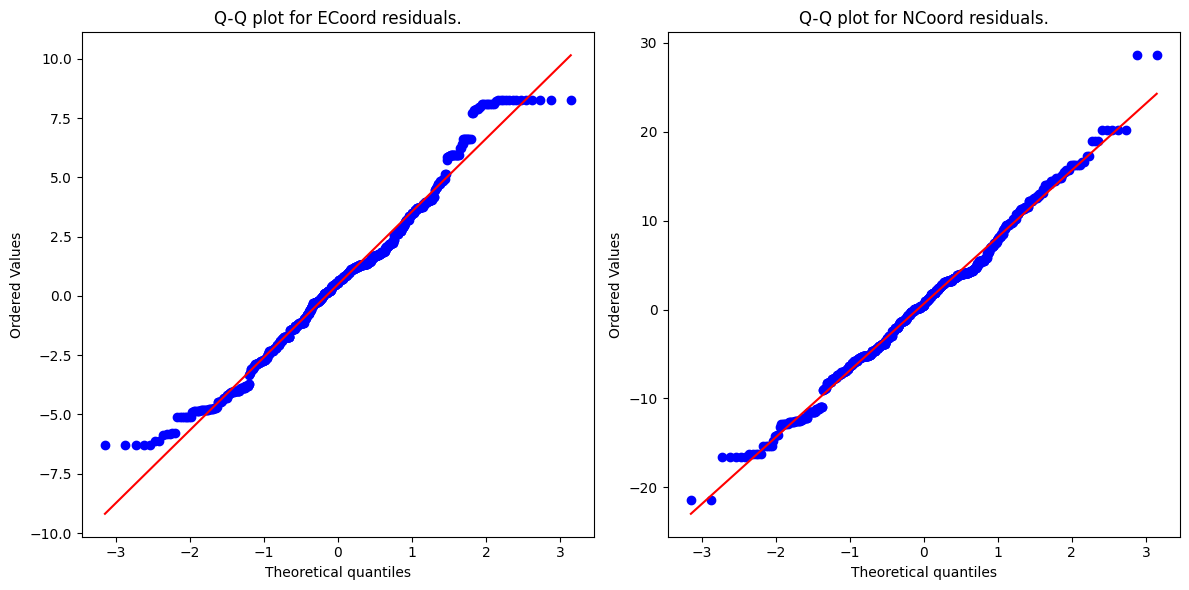

In [297]:
qq_plot(residuals)

The residual plots for ECoord and NCoord show that there is a pattern in the residuals for ECoord, with larger errors as the predicted value increases. This could indicate heteroscedasticity, which means the variance of the errors is not constant across all levels of the predictor variable. The residuals for NCoord seem more randomly scattered, but there is still some structure visible.
I will try to address that by removing outliers and/or log transforming first.

In [199]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

Y_train = train_data[output_variables]
Y_test = test_data[output_variables]

# Remove outliers based on Z-score for ECoord and NCoord
z_scores = np.abs(stats.zscore(Y_train))
outliers = (z_scores > 3).any(axis=1)
X_train = train_data_input[~outliers]
Y_train = Y_train[~outliers]

pca = PCA(n_components=0.77)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(test_data_input)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

param_distributions = {
    'min_samples': randint(low=2, high=int(X_train.shape[0]*0.5)),
    'residual_threshold': randint(low=1, high=20)
}

ransac = RANSACRegressor(estimator=LinearRegression(),
                         min_samples=int(X_train.shape[0]*0.5),  
                         residual_threshold=15,  # Since most residuals were between (-10, 10)
                         max_trials=100,  
                         random_state=42)  

ransac_random_search = RandomizedSearchCV(ransac, param_distributions=param_distributions,
                                          n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1, error_score='raise')


ransac_random_search.fit(X_train, Y_train)
best_ransac = ransac_random_search.best_estimator_
best_cv_score = -ransac_random_search.best_score_

# Now you can predict with the RANSAC model and evaluate as before
Y_test_pred = best_ransac.predict(X_test)
test_rmse = root_mean_squared_error(Y_test, Y_test_pred)

(best_cv_score) ** 0.5, test_rmse

(20.10126144230193, 4.847736216437042)

C:\Users\gps18.REMAINHEALTHY\AppData\Local\Temp\ipykernel_24276\2691015462.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 100)


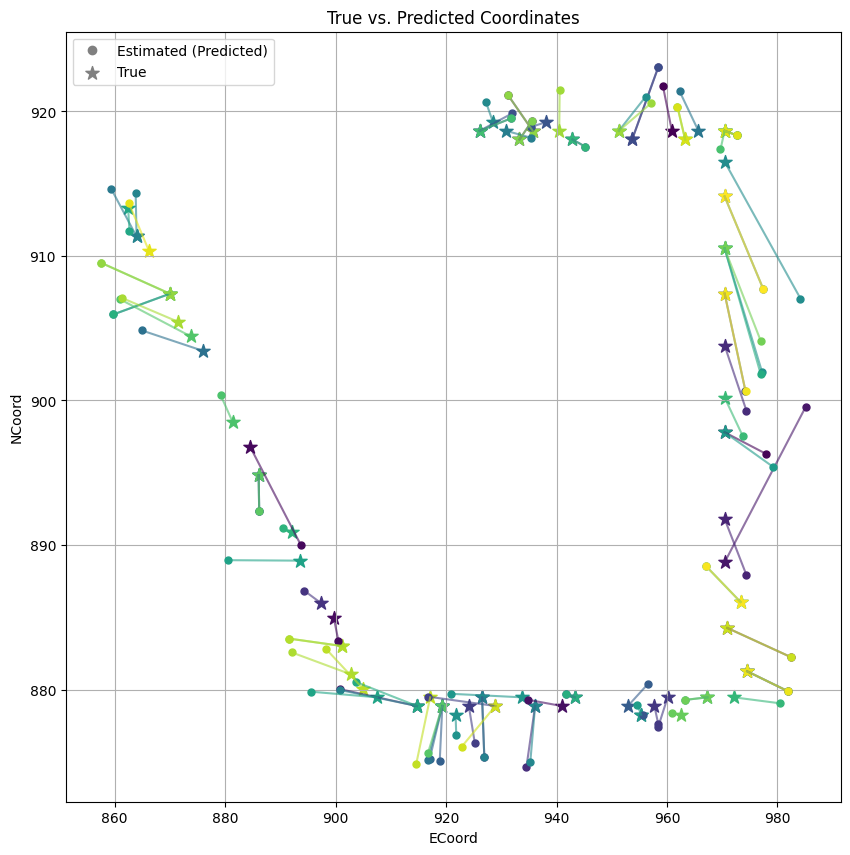

In [200]:
true_vs_predicted(X_test, Y_test, best_ransac)

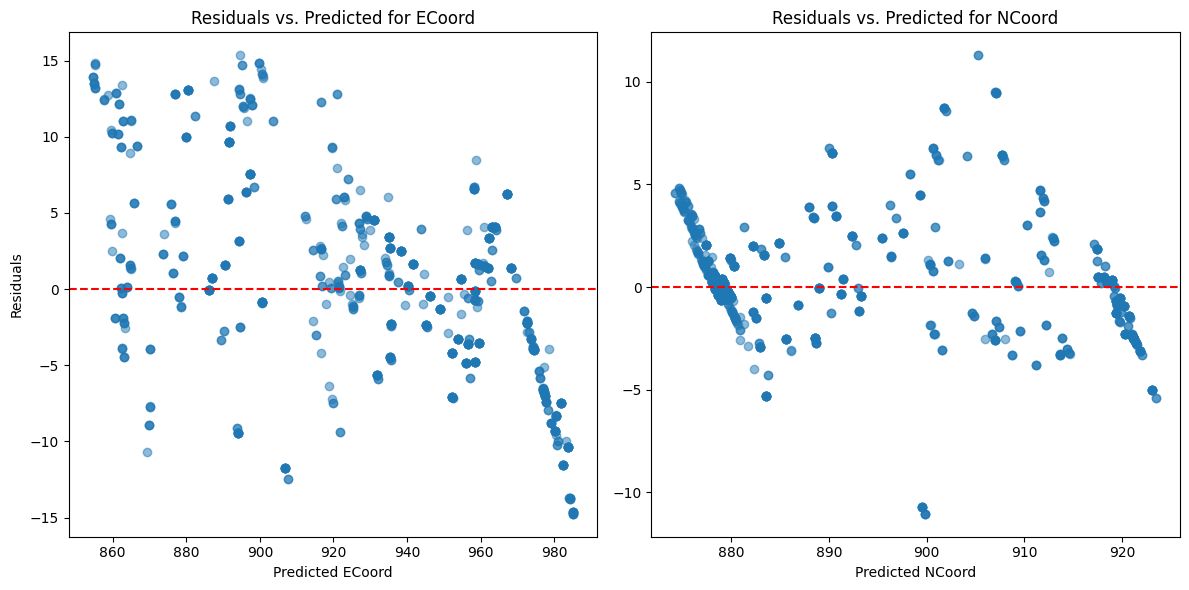

In [201]:
# Assuming `y_test` and `y_pred` are your true target values and predictions, respectively, each with two columns: ECoord and NCoord
residuals = Y_test - Y_test_pred  # Residuals for NCoord

residual_plot_both(Y_test_pred, residuals)

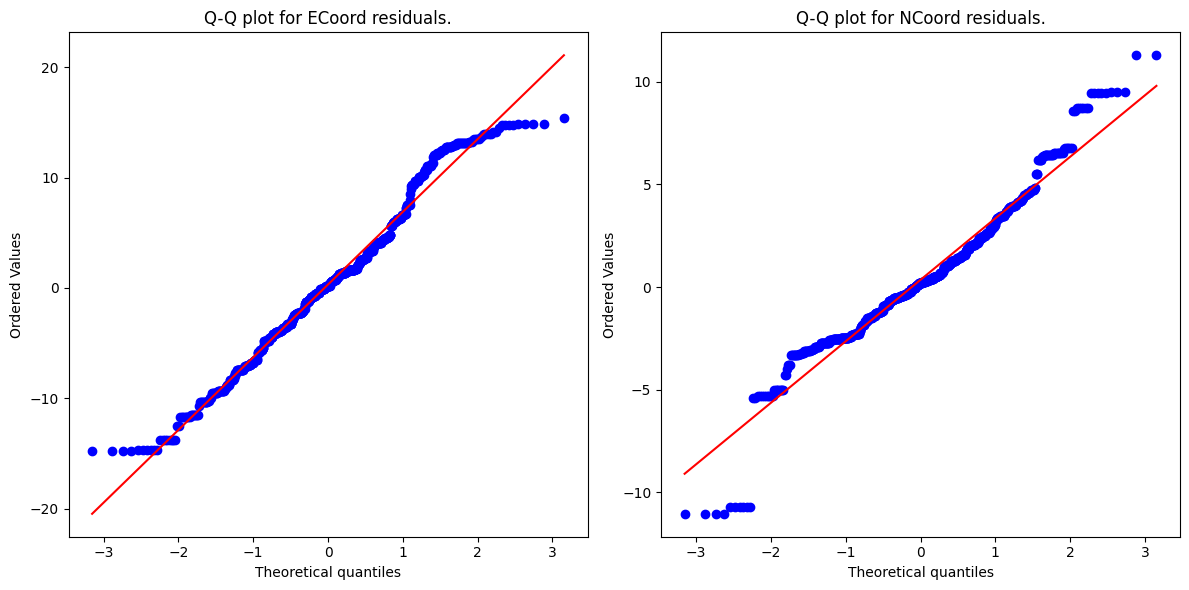

In [202]:
qq_plot(residuals)